In [1]:
import random
import helper
import models
import numpy as np
import pandas as pd
import importlib as imp
from datetime import datetime
from matplotlib import pyplot as plt
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, utils

rs = 2018
random.seed(rs)
%matplotlib inline

## Get the tensor data

In [2]:
use_cuda = torch.cuda.is_available()
print('Using cuda: {}'.format(use_cuda))
torch.manual_seed(rs)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
batch_size = 1000

Using cuda: False


In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=True, split='digits', download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=False, split='digits', transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader_ordered = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=False, split='digits', transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=len(test_loader.dataset), shuffle=False, **kwargs)

## Train and test a 1 layer model

**Note:** Netx represents an x layer network between 1 and 4 layers

In [4]:
model = models.Net1(dropout_rate=0.2, n_filters=10, filter_size=5, fc_units=50)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
start = datetime.now() 
for epoch in range(1):
    models.train(model, optimizer, train_loader, use_cuda, device, epoch, layers=1)
    print('Time elapsed {}'.format(datetime.now() - start))
    test_loss, correct = models.test(model, optimizer, test_loader, use_cuda, device, epoch, layers=1)


Train Epoch: 0 [0/240000 (0%)]	Loss: 2.319825
Train Epoch: 0 [10000/240000 (4%)]	Loss: 2.286458
Train Epoch: 0 [20000/240000 (8%)]	Loss: 2.282016
Train Epoch: 0 [30000/240000 (12%)]	Loss: 2.266489
Train Epoch: 0 [40000/240000 (17%)]	Loss: 2.246410
Train Epoch: 0 [50000/240000 (21%)]	Loss: 2.223020
Train Epoch: 0 [60000/240000 (25%)]	Loss: 2.200586
Train Epoch: 0 [70000/240000 (29%)]	Loss: 2.200578
Train Epoch: 0 [80000/240000 (33%)]	Loss: 2.185060
Train Epoch: 0 [90000/240000 (38%)]	Loss: 2.166213
Train Epoch: 0 [100000/240000 (42%)]	Loss: 2.141095
Train Epoch: 0 [110000/240000 (46%)]	Loss: 2.119829
Train Epoch: 0 [120000/240000 (50%)]	Loss: 2.085577
Train Epoch: 0 [130000/240000 (54%)]	Loss: 2.073129
Train Epoch: 0 [140000/240000 (58%)]	Loss: 2.051764
Train Epoch: 0 [150000/240000 (62%)]	Loss: 2.012164
Train Epoch: 0 [160000/240000 (67%)]	Loss: 1.988908
Train Epoch: 0 [170000/240000 (71%)]	Loss: 1.980766
Train Epoch: 0 [180000/240000 (75%)]	Loss: 1.935532
Train Epoch: 0 [190000/240000

In [5]:
print('Test loss: {0:4.3f}'.format(test_loss))
print('Correct: {0:3.2f}%'.format(correct*100.))

Test loss: 1.732
Correct: 71.95%


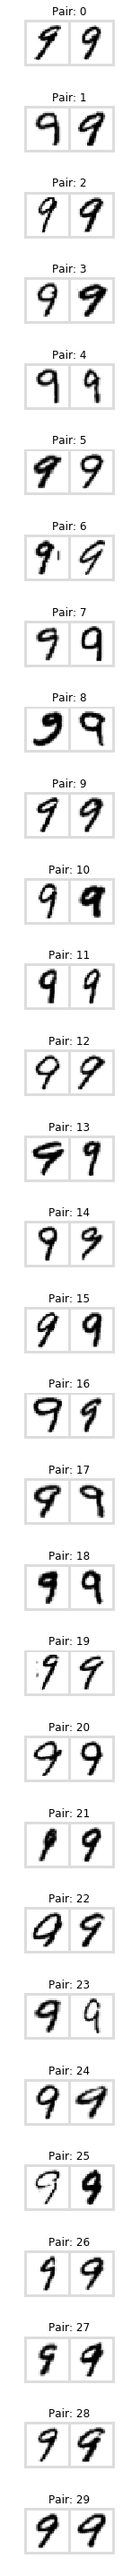

In [6]:
imp.reload(helper) # I don't really need to keep reloading this, but, meh, who cares
ix1, ix2, im1, im2 = helper.get_random_subset(test_loader_ordered, use_cuda, 9, npairs=30)

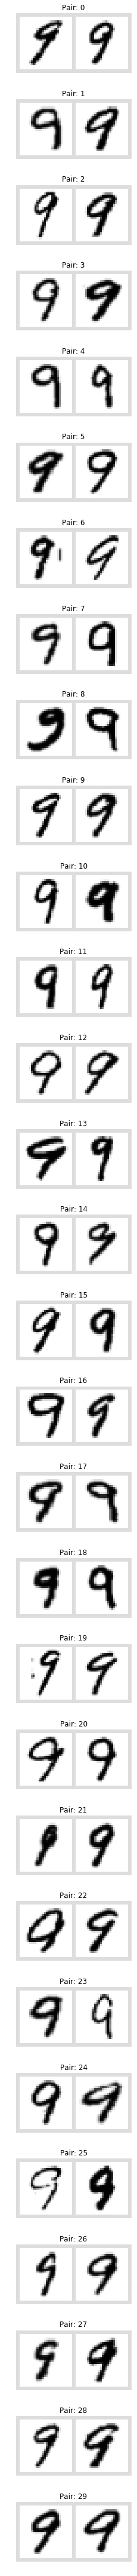

In [7]:
imp.reload(helper)
helper.plot_image_pairs(im1,im2)

In [8]:
imp.reload(helper)
helper.get_similarity_scores(im1,im2,model,layer='fc')

array([0.92310309, 0.87637258, 0.93789119, 0.94733816, 0.96125233,
       0.9287535 , 0.73402816, 0.87476629, 0.75504011, 0.94313854,
       0.94881648, 0.93539518, 0.84505761, 0.86998349, 0.91554356,
       0.86641693, 0.75144154, 0.8651498 , 0.94072878, 0.9250775 ,
       0.98177695, 0.86954212, 0.69952458, 0.90002012, 0.90673959,
       0.9378702 , 0.93859035, 0.8747052 , 0.90690267, 0.9215793 ])

### This might be useful?

In [9]:
for name, param in model.named_parameters():
    print(name)
layers = [name.split('.')[0] for name, param in model.named_parameters() if all(x not in name for x in ('bias','fc2'))]
layers

conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


['conv1', 'fc1']